In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Ignore specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Load the dataset
spotify_data = pd.read_csv('Spotify_Dataset_Cat.csv')
spotify_data = spotify_data.loc[:, :'genre_1']

spotify_data.head()

,valence,year,acousticness,artists_combined,danceability,duration_ms,energy,explicit,id,instrumentalness,...,loudness,mode,name,popularity,release_date,speechiness,tempo,artist_count,artist_1,genre_1
0,0.826,1921,0.995,['Maurice Chevalier'],0.463,147133,0.260,0,0BMkRpQtDoKjcgzCpnqLNa,0.0,...,-16.894,1,Dans La Vie Faut Pas S'en Faire,0,1/1/1921,0.0557,85.146,1,Maurice Chevalier,Music-hall
1,0.678,1921,0.996,['Maurice Chevalier'],0.500,181733,0.274,0,0i7MdVu0tNEyUdgpCBilKe,0.0,...,-14.001,1,Je M'donne,0,1/1/1921,0.0410,79.218,1,Maurice Chevalier,Music-hall
2,0.651,1921,0.992,['Maurice Chevalier'],0.522,170627,0.290,0,1RgXfAX9PrSfTKTFvOQxPR,0.0,...,-12.194,0,Je N'peux Pas Vivre Sans Amour,0,1/1/1921,0.0522,92.707,1,Maurice Chevalier,Music-hall
3,0.767,1921,0.995,['Maurice Chevalier'],0.517,169173,0.271,0,39ZYlUAoqyE05y7rsfeivo,0.0,...,-15.487,0,Pour Bien Reussir Dans La Chaussure,0,1/1/1921,0.0551,90.390,1,Maurice Chevalier,Music-hall
4,0.775,1921,0.996,['Maurice Chevalier'],0.526,153973,0.247,0,4wX1xtFyqlhBMBX7xaOfNB,0.0,...,-13.680,1,Avec Le Sourire,0,1/1/1921,0.0483,83.837,1,Maurice Chevalier,Music-hall


In [2]:
# Select relevant features for PCA and Anomaly Detection
features = ['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'duration_ms', 'explicit']
spotify_features = spotify_data[features]
spotify_features.head()

,valence,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,duration_ms,explicit
0,0.826,0.995,0.463,0.260,0.0,0.258,0.0557,85.146,147133,0
1,0.678,0.996,0.500,0.274,0.0,0.302,0.0410,79.218,181733,0
2,0.651,0.992,0.522,0.290,0.0,0.381,0.0522,92.707,170627,0
3,0.767,0.995,0.517,0.271,0.0,0.368,0.0551,90.390,169173,0
4,0.775,0.996,0.526,0.247,0.0,0.116,0.0483,83.837,153973,0


In [3]:
# Anomaly Detection using Isolation Forest algorithn
# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# Fit the model
iso_forest.fit(spotify_features)

# Predict anomalies (-1 for outliers and 1 for inliers)
spotify_data['anomaly'] = iso_forest.predict(spotify_features)

# Filter the anomalies
anomalies = spotify_data[spotify_data['anomaly'] == -1]
normal = spotify_data[spotify_data['anomaly'] == 1]

# Filter out rows with blank or null values in 'genre_1'
anomalies_filtered = anomalies[anomalies['genre_1'].notna()]

# Display the filtered anomalies
print("Filtered Anomalies:")
print(anomalies_filtered[['artists_combined', 'name', 'year', 'genre_1']])

Filtered Anomalies:
                      artists_combined                         name  year  \
91                    ['Tommy Dorsey']                 Easy Does It  1925   
156                  ['Benny Goodman']                     Roll 'Em  1928   
159                  ['Benny Goodman']            King Porter Stomp  1928   
163                  ['Benny Goodman']                      Goodbye  1928   
451                ['Louis Armstrong']              St. Louis Blues  1934   
...                                ...                          ...   ...   
55302                 ['Jeremy Soule']                       Masser  2013   
55326                 ['Jeremy Soule']                Journey's End  2013   
55339                 ['Jeremy Soule']              The White River  2013   
55534    ['21 Savage', 'Metro Boomin']                   Real Nigga  2016   
55779  ['Anderson .Paak', 'Rick Ross']  CUT EM IN (feat. Rick Ross)  2020   

         genre_1  
91      Big band  
156        swing 

In [4]:
# Rename 'genre_1' column to 'genre' in the filtered anomalies DataFrame
anomalies_filtered = anomalies_filtered.rename(columns={'genre_1': 'genre'})

# Save the filtered anomalies to a CSV file
anomalies_filtered.to_csv('filtered_anomalies.csv', index=False)

* The anomalies include notable artists like Tommy Dorsey, Benny Goodman, Lata Mangeshkar, and Louis Armstrong, who are prominent figures in genres like Big Band, Swing, Classical, and Jazz. These genres and artists were particularly influential in the early to mid-20th century.
* The songs show a variety of values across musical features like valence, acousticness, danceability, energy, and instrumentalness. For example, "Easy Does It" by Tommy Dorsey has a relatively high valence (0.784) and instrumentalness (0.860), indicating a cheerful and instrumental-heavy track.
* The explicit column indicates that these tracks do not contain explicit content, which aligns with the norms of earlier recording eras.

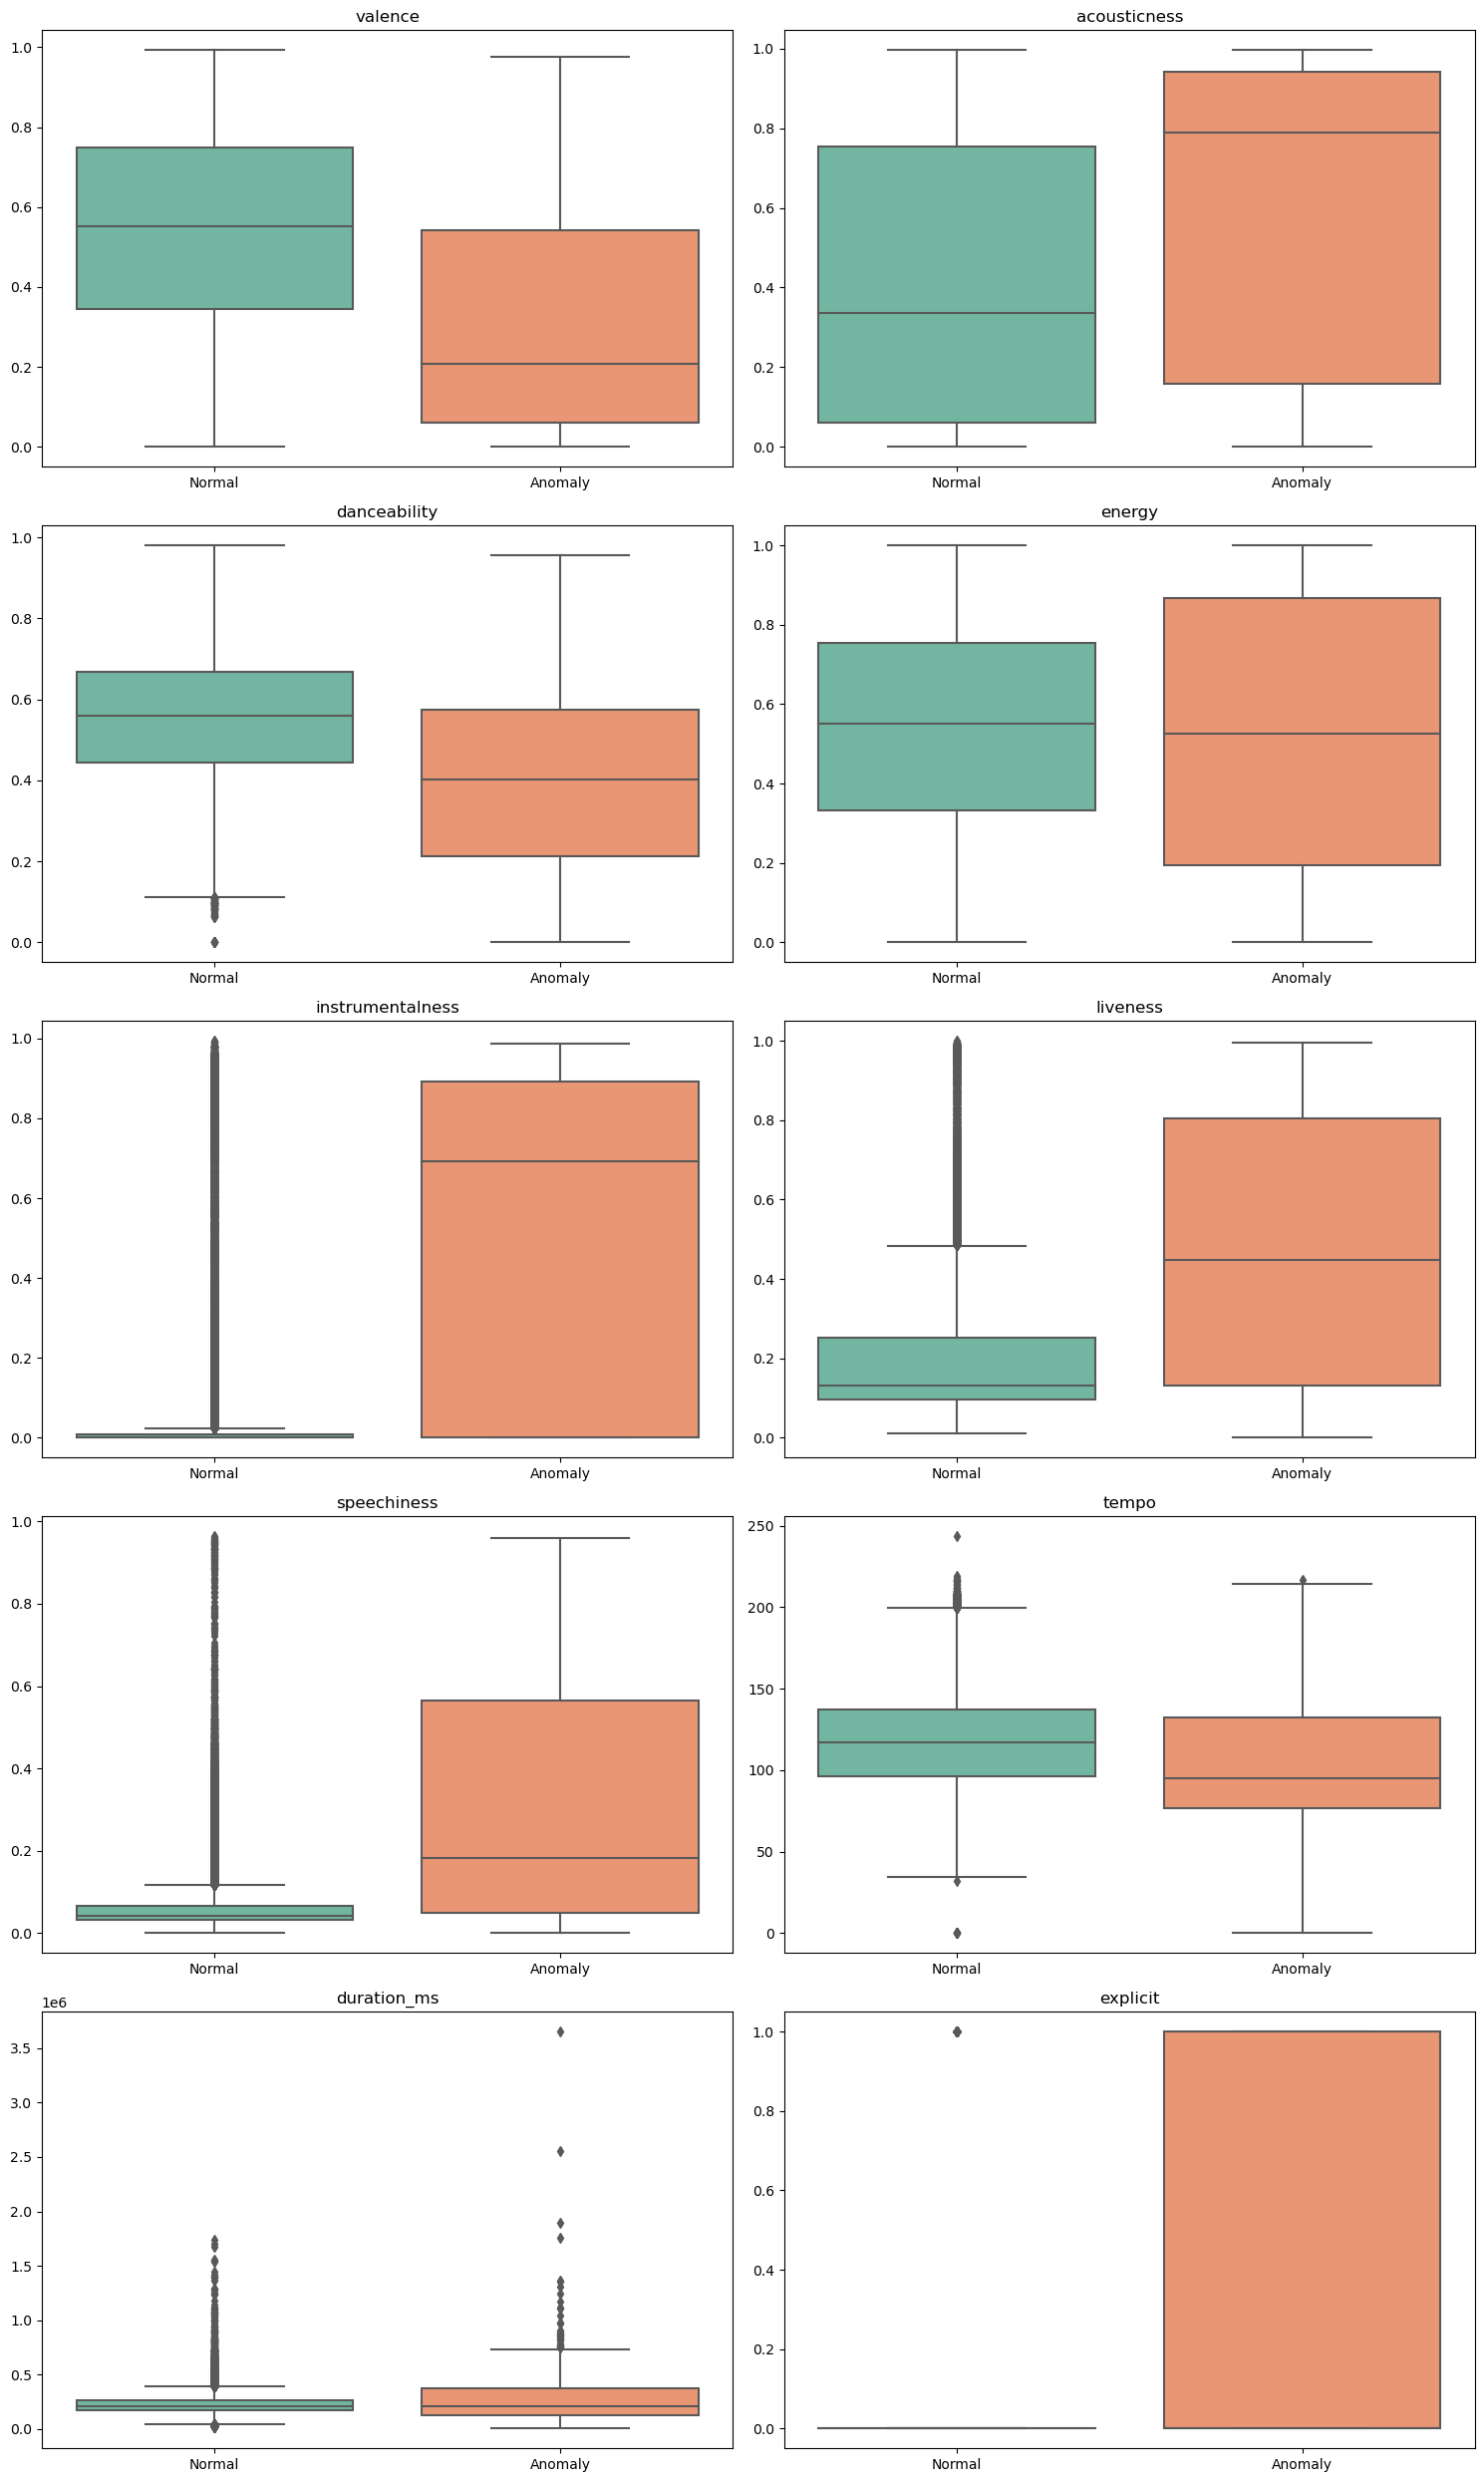

In [5]:
# Visualization using Box Plots
plt.figure(figsize=(15, 25))
for i, feature in enumerate(features, 1):
    plt.subplot(5, 2, i)  # 5 rows, 2 columns
    sns.boxplot(data=[normal[feature], anomalies[feature]], palette="Set2")
    plt.xticks([0, 1], ['Normal', 'Anomaly'])
    plt.title(feature)

plt.tight_layout()
plt.show()